## Mathematical Modeling of El Niño–Southern Oscillation Dynamics

This notebook contains simulates El Niño–Southern Oscillation (ENSO) dynamics using PDEs, proper orthogonal decomposition (POD), and Sparse Identification of Nonlinear Dynamics (SINDy).

**Authors:** Erica Han, Joanna Jiang, Katrina Wohlgemut, Yusuf Aydogdu

<a href="https://colab.research.google.com/github/ericahan22/ENSO-modelling/blob/main/ENSO_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg as LA

## Set up modelling and simulation parameters

| **Parameter** | **Value** | **Description** |
|--------------|-----------|-----------------|
| $c$          | $0.5$       | Ocean phase speed |
| $\chi_A$        | $0.3$       | Meridional projection coefficient (atmosphere) |
| $\chi_O$        | $1$         | Meridional projection coefficient (ocean) |
| $\xi$          | $1$         | Latent heating exchange coefficient |
| $\alpha_q$        | $3$         | Latent heating factor |
| $\gamma$          | $6.5$       | Wind stress coefficient |
| $\eta(x)$       | $1.5 + 0.5\cdot\tanh(7.5(x − L/2))$ | Profile of thermocline feedback |
| $\hat{Q}$         | $0.01$      | Mean vertical moisture gradient |
| $M$          | $8000$  | Number of time steps |
| $N$          | $200$   | Number of space steps |
| $L$          | $1$         | Space length |
| $T_f$        | $40$        | Time length |

In [ ]:
M = 8000    # Time points
N = 200     # Space points
KA = np.zeros([M, N])
KO = np.zeros([M, N])
RA = np.zeros([M, N])
RO = np.zeros([M, N])
T = np.zeros([M, N])

Tf = 40
L = 1
x = np.linspace(0, L, N)
t = np.linspace(0, Tf, M)
dt = t[1] - t[0]
dx = x[1] - x[0]

chi_A = 0.3
alpha_q = 3
Qhat = 0.01
c0 = 0.5
chi_0 = 1
gamma = 6.5
xsi = 1
Q_1 = chi_A * alpha_q * (1/(2-2*Qhat))
Q_2 = chi_A * alpha_q * (1/(3-3*Qhat))
Q_3 = c0 * chi_0 * gamma / 2
Q_4 = -chi_0 * c0 * gamma / 3
Q_5 = -c0 * xsi * alpha_q
eta = 1.5 + (0.5 * np.tanh(7.5 * (x - L/2)))
rW = 0.5
rE = 0.5

KO[0, :] = np.linspace(0.5, 0.25, N)
RO[0, 0] = (1 / rW) * KO[0, 0]
RO[0, N-1] = rE * KO[0, N-1]
RO[0, :] = np.linspace(RO[0, 0], RO[0, N-1], N)
T[0, :] = np.linspace(0.75, -0.75, N)


## Plotting the initial conditions and thermocline feedback profile

In [ ]:
plt.figure(figsize=(10, 6))

plt.plot(x, KO[0, :], label='KO (Initial Ocean State)', linewidth=2)
plt.plot(x, RO[0, :], label='RO (Initial Ocean Response)', linewidth=2)
plt.plot(x, T[0, :], label='T (Initial Temperature)', linewidth=2)
plt.plot(x, eta, label='η (Thermocline Feedback Profile)', linestyle='--', color='black')

plt.title('Initial Conditions and Thermocline Feedback', fontsize=14)
plt.xlabel('Spatial Position $x$', fontsize=12)
plt.ylabel('Field Value', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# i = time, j = space
for i in range(M-1):
    for j in range(1, N):
      KA[i+1, 0] = KA[i, 0] - (dt / dx) * (KA[i, 0] - rW * RA[i, 0]) + Q_1 * dt * T[i, 0]
      KA[i+1, j] = KA[i, j] - (dt / dx) * (KA[i, j] - KA[i, j-1]) + Q_1 * dt * T[i, j]
    for j in range(N-1):
      RA[i+1, j] = RA[i, j] + (dt / (3 * dx)) * (RA[i, j+1] - RA[i, j]) + Q_2 * dt * T[i, j]
      RA[i+1, N-1] = RA[i, N-1] + (dt / (3 * dx)) * (rE * KA[i, N-1] - RA[i, N-1]) + Q_2 * dt * T[i, N-1]
    for j in range(1, N):
      KO[i+1, 0] = KO[i, 0] - (c0 * dt / dx) * (KO[i, 0] - rW * RO[i, 0]) + Q_3 * dt *(KA[i, 0] - RA[i, 0])
      KO[i+1, j] = KO[i, j] - (c0 * dt / dx) * (KO[i, j] - KO[i, j-1]) + Q_3 * dt * (KA[i, j] - RA[i, j])
    for j in range(N-1):
      RO[i+1, j] = RO[i, j] + (c0 * dt / (3 * dx)) * (RO[i, j+1] - RO[i, j]) + Q_4 * dt * (KA[i, j] - RA[i, j])
      RO[i+1, N-1] = RO[i, N-1] + (c0 * dt / (3 * dx)) * (rE * KO[i, N-1] - RO[i, N-1]) + Q_4 * dt * (KA[i, N-1] - RA[i, N-1])
    for j in range(N):
      T[i+1, j] = T[i, j] + Q_5 * dt * T[i, j] + dt * c0 * eta[j] * (KO[i, j] + RO[i, j])

In [ ]:
print(T)

[[ 0.75        0.74246231  0.73492462 ... -0.73492462 -0.74246231
  -0.75      ]
 [ 0.74812684  0.74063171  0.73313659 ... -0.72748085 -0.73499021
  -0.74249958]
 [ 0.7462659   0.73881458  0.73136171 ... -0.72009342 -0.72757468
  -0.7350523 ]
 ...
 [ 0.29627742  0.2960438   0.29568804 ...  0.05557778  0.05773321
   0.05983256]
 [ 0.29631031  0.29605644  0.29568054 ...  0.05795144  0.0601118
   0.06221565]
 [ 0.29633619  0.29606207  0.29566603 ...  0.06032426  0.06248952
   0.06459782]]


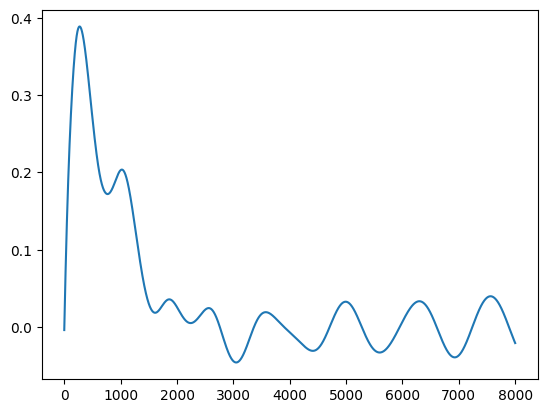

In [ ]:
plt.plot(T[:, 100])

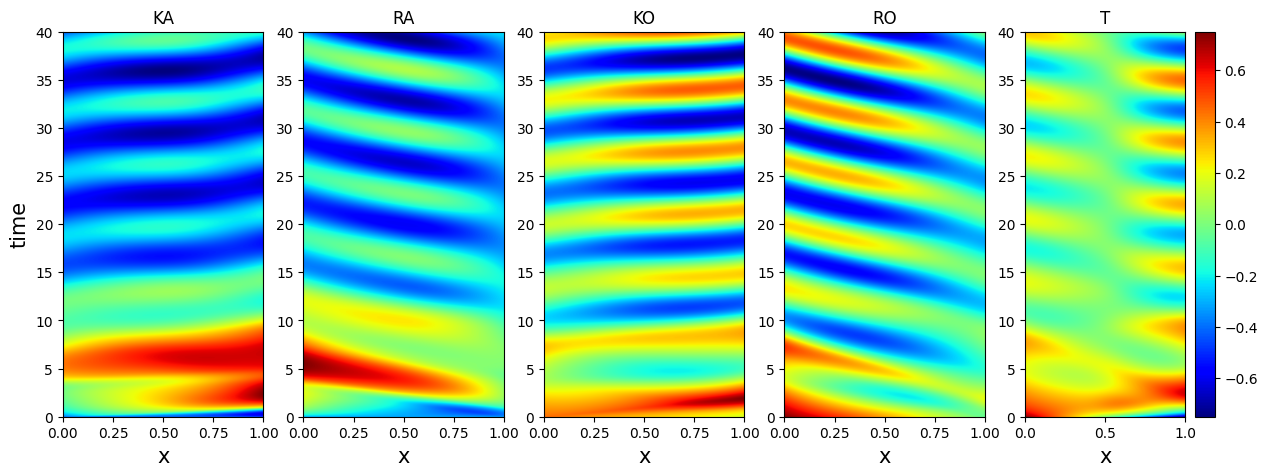

In [ ]:
fig, ax = plt.subplots(1, 5, figsize=(15, 5))

c1 = ax[0].imshow(KA[:, :], aspect='auto', extent=[x.min(), x.max(), t.max(), t.min()], cmap='jet')
ax[0].set_xlabel('x', fontsize=15)
ax[0].set_ylabel('time', fontsize=15)
ax[0].set_title('KA')
ax[0].invert_yaxis()  # Invert y-axis to have time go from bottom to top
#fig.colorbar(c1, ax=ax[0], orientation='vertical')

c2 = ax[1].imshow(RA[:,:], aspect='auto', extent=[x.min(), x.max(), t.max(), t.min()], cmap='jet')
ax[1].set_xlabel('x', fontsize=15)
#ax[1].set_ylabel('T', fontsize=15)
ax[1].set_title('RA')
ax[1].invert_yaxis()  # Invert y-axis to have time go from bottom to top
#fig.colorbar(c2, ax=ax[1], orientation='vertical')

c3 = ax[2].imshow(KO[:, :], aspect='auto', extent=[x.min(), x.max(), t.max(), t.min()], cmap='jet')
ax[2].set_xlabel('x', fontsize=15)
#ax[2].set_ylabel('T', fontsize=15)
ax[2].set_title('KO')
ax[2].invert_yaxis()  # Invert y-axis to have time go from bottom to top
#fig.colorbar(c3, ax=ax[2], orientation='vertical')

c4 = ax[3].imshow(RO[:,:], aspect='auto', extent=[x.min(), x.max(), t.max(), t.min()], cmap='jet')
ax[3].set_xlabel('x', fontsize=15)
#ax[3].set_ylabel('T', fontsize=15)
ax[3].set_title('RO')
ax[3].invert_yaxis()  # Invert y-axis to have time go from bottom to top
#fig.colorbar(c4, ax=ax[3], orientation='vertical')

c5 = ax[4].imshow(T[:, :], aspect='auto', extent=[x.min(), x.max(), t.max(), t.min()], cmap='jet')
ax[4].set_xlabel('x', fontsize=15)
#ax[4].set_ylabel('T', fontsize=15)
ax[4].set_title('T')
ax[4].invert_yaxis()  # Invert y-axis to have time go from bottom to top
fig.colorbar(c5, ax=ax[4], orientation='vertical')

In [ ]:
svd = np.linalg.svd(T)

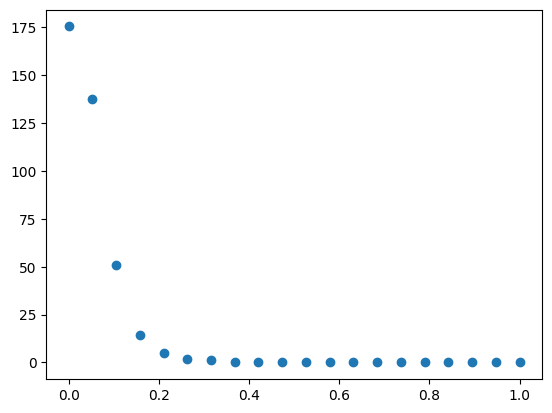

In [ ]:
xx = np.linspace(0, 1, 20)
plt.scatter(xx, svd[1][:20])
plt.show()

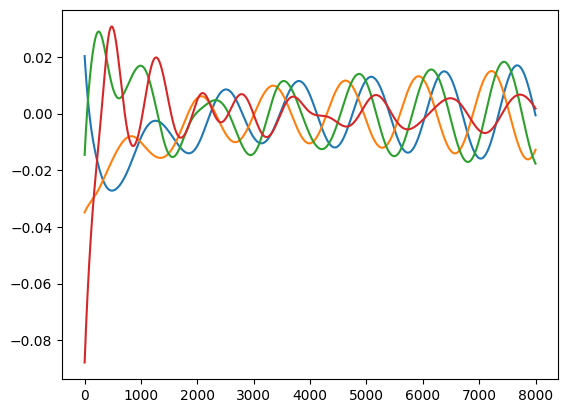

In [ ]:
for k in range(4):
  plt.plot(svd[0][:, k])
plt.show()

In [ ]:
C_KA=np.matmul(KA,KA.T)
C_RA=np.matmul(RA,RA.T)
C_KO=np.matmul(KO,KO.T)
C_RO=np.matmul(RO,RO.T)
C_T=np.matmul(T,T.T)

In [ ]:
np.shape(C_RA)

(8000, 8000)

In [ ]:
C=(C_KA+C_RA+C_KO+C_RO+C_T)/M

In [ ]:
print(np.shape(C))

(8000, 8000)


In [ ]:
from numpy import linalg as LA
eig,y=LA.eig(C)

/usr/local/lib/python3.11/dist-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/usr/local/lib/python3.11/dist-packages/matplotlib/collections.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


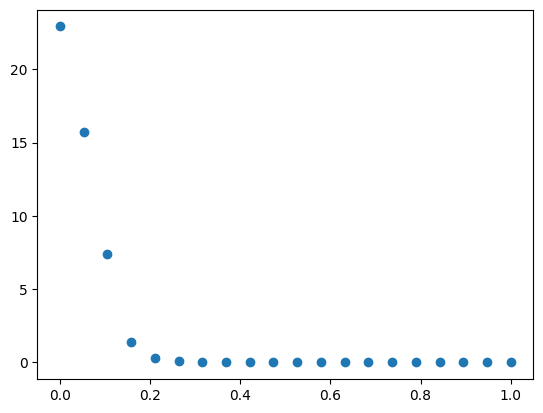

In [ ]:

plt.scatter(xx,eig[:20])

In [ ]:
R=4

In [ ]:
phi_KA=np.zeros([R,N])
phi_RA=np.zeros([R,N])
phi_KO=np.zeros([R,N])
phi_RO=np.zeros([R,N])
phi_T=np.zeros([R,N])

In [ ]:
for k in range(R):
  for i in range(M):
    phi_KA[k,:] +=(np.real(y[i,k])*KA[i,:])/np.sqrt(M*np.real(eig[k]))
    phi_RA[k,:] +=(np.real(y[i,k])*RA[i,:])/np.sqrt(M*np.real(eig[k]))
    phi_KO[k,:] +=(np.real(y[i,k])*KO[i,:])/np.sqrt(M*np.real(eig[k]))
    phi_RO[k,:] +=(np.real(y[i,k])*RO[i,:])/np.sqrt(M*np.real(eig[k]))
    phi_T[k,:] +=(np.real(y[i,k])*T[i,:])/np.sqrt(M*np.real(eig[k]))


In [ ]:
print(np.shape(phi_KA))

(4, 200)


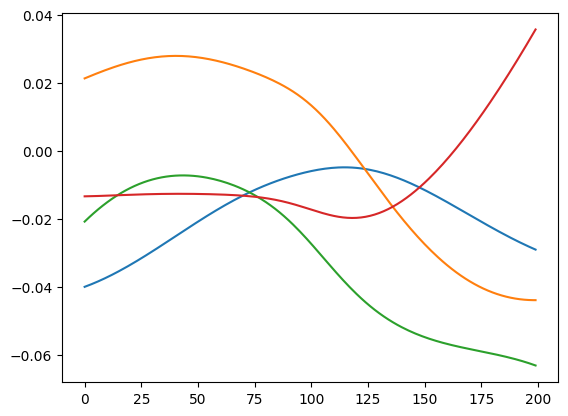

In [ ]:
for j in range(R):
  plt.plot(phi_T[j,:])
plt.show()

/usr/local/lib/python3.11/dist-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


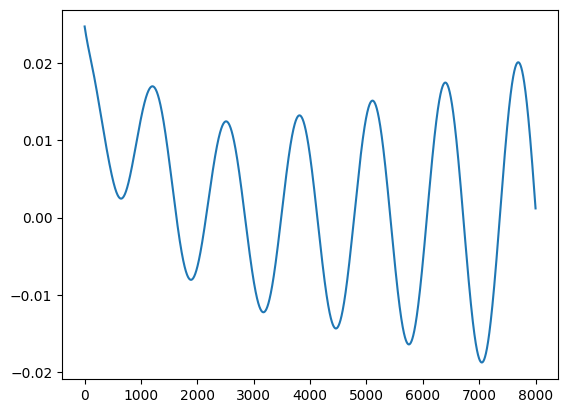

In [ ]:
plt.plot(y[:,1])

In [ ]:
Psi=np.zeros([5*N,R])
for i in range(R):
  for k in range(N):
    Psi[k,i]=phi_KA[i,k]
    Psi[k+N,i]=phi_RA[i,k]
    Psi[k+2*N,i]=phi_KO[i,k]
    Psi[k+3*N,i]=phi_RO[i,k]
    Psi[k+4*N,i]=phi_T[i,k]

In [ ]:
q=np.zeros([M,R])
W=np.zeros([M,5*N])
W=np.hstack((KA,RA,KO,RO,T))
print(np.shape(W))
print(np.shape(Psi))
q=np.matmul(W,Psi)

(8000, 1000)
(1000, 4)


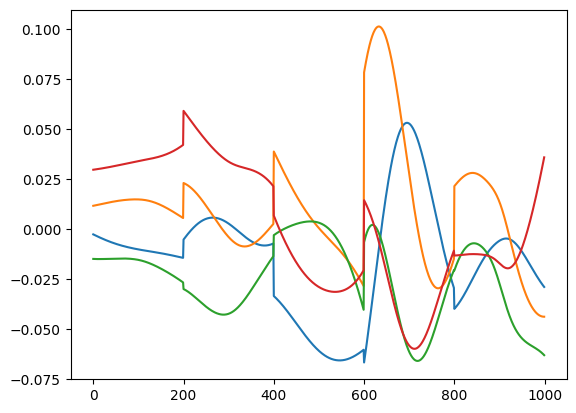

In [ ]:
for j in range(R):
  plt.plot(Psi[:,j])
plt.show()

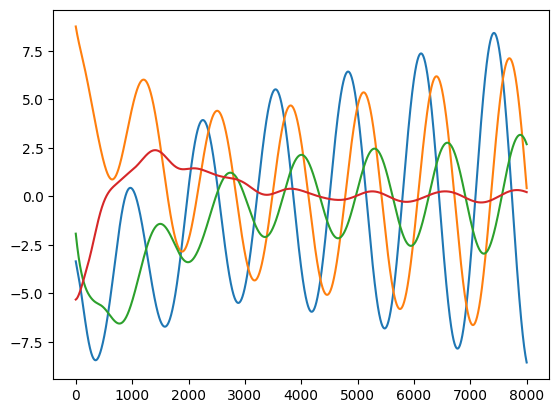

In [ ]:
for j in range(R):
  plt.plot(q[:,j])
plt.show()

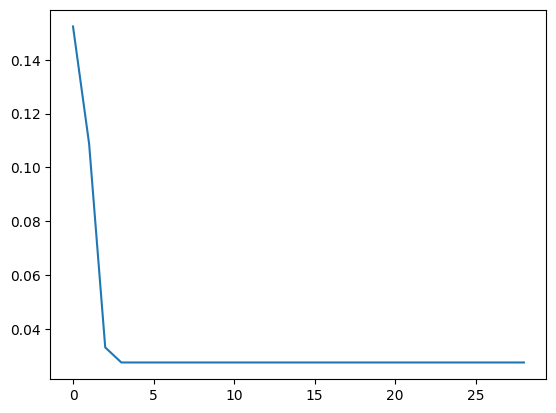

In [ ]:
rmse = []
for i in range(1, 30):
    rmse.append(np.sqrt(np.sum((T - q[:,:i] @ phi_T[:i,:])**2) / (M*N)))
plt.plot(rmse)

In [ ]:
# Import libraries
!pip install pysindy
import numpy as np
import pysindy as ps

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.0/121.0 kB 3.9 MB/s eta 0:00:00


In [ ]:
np.shape(q)

(8000, 4)

In [ ]:
X= np.stack((q[:,0], q[:,1], q[:,2], q[:,3]), axis = -1)

In [ ]:
np.shape(X)

(8000, 4)

In [ ]:
# Select differentiation method, library, and optimization technique
differentiation_method = ps.FiniteDifference(order=2)
feature_library = ps.PolynomialLibrary(degree=3)
optimizer = ps.STLSQ(threshold=0.02)

model = ps.SINDy(
    differentiation_method=differentiation_method,
    feature_library=feature_library,
    optimizer=optimizer,
    feature_names=["q1", "q2", "q3", "q4"],
)

In [ ]:
import math
np.math = math

In [ ]:
model.fit(X, t=t)
model.print()

ValueError: solve: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (m,m),(m,n)->(m,n) (size 1 is different from 3)

In [ ]:
import pandas as pd
coefficients = model.coefficients()
feature_names = model.get_feature_names()
df = pd.DataFrame(coefficients, columns=feature_names, index=["q1'", "q2'", "q3'", "q4'"]).T
formatted_df = df.applymap(lambda x: f"{x:.4f}" if x != 0 else "0")
print(formatted_df)

In [ ]:
initial_cond = [q[0,0], q[0,1], q[0,2], q[0,3]]

In [ ]:
sim = model.simulate(initial_cond, t=t)

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

axs[0,0].plot(t, X[:,0], "b", label="Exact solution", alpha=0.4, linewidth=4)
axs[0,0].plot(t, sim[:, 0], "k--", label="SINDy model", linewidth=3)
axs[0,0].set_xlabel("Time")
axs[0,0].set_ylabel("Amplitude")
axs[0,0].set_title("q1")
axs[0,0].legend()

axs[0,1].plot(t, X[:,1], "b", label="Exact solution", alpha=0.4, linewidth=4)
axs[0,1].plot(t, sim[:, 1], "k--", label="SINDy model", linewidth=3)
axs[0,1].set_xlabel("Time")
axs[0,1].set_ylabel("Amplitude")
axs[0,1].set_title("q2")
axs[0,1].legend()

axs[1,0].plot(t, X[:,2], "b", label="Exact solution", alpha=0.4, linewidth=4)
axs[1,0].plot(t, sim[:, 2], "k--", label="SINDy model", linewidth=3)
axs[1,0].set_xlabel("Time")
axs[1,0].set_ylabel("Amplitude")
axs[1,0].set_title("q3")
axs[1,0].legend()

axs[1,1].plot(t, X[:,3], "b", label="Exact solution", alpha=0.4, linewidth=4)
axs[1,1].plot(t, sim[:, 3], "k--", label="SINDy model", linewidth=3)
axs[1,1].set_xlabel("Time")
axs[1,1].set_ylabel("Amplitude")
axs[1,1].set_title("q4")
axs[1,1].legend()

plt.show()

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

for j in range(R):
  axs[0].plot(t, q[:,j])
axs[0].set_title('Real Equations')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Amplitude')

for j in range(R):
  axs[1].plot(t, sim[:,j])
axs[1].set_title('SINDy Model')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Amplitude')

plt.show()